<a href="https://colab.research.google.com/github/rm-rf-humans/QNN/blob/main/H_QNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.1 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
from torchvision import transforms
from pennylane import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from PIL import Image
import pandas as pd
import numpy as np
import shutil
import torch
import os
from IPython.display import display
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import recall_score

In [ ]:
class BreastCancerDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("L")
        label = 0 if 'normal' in img_path else 1

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
normal_dir = "normal"
abnormal_dir = "abnormal"
output_dir = "output/"
transform = transforms.Compose([transforms.ToTensor()])

In [ ]:
def split_separate_folders(normal_dir, abnormal_dir, output_dir, train_ratio=0.7,
                         val_ratio=0.15, test_ratio=0.15, random_state=42):

    splits = ['train', 'val', 'test']
    classes = ['normal', 'abnormal']

    for split in splits:
        for cls in classes:
            os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

    results = {
        'Class': [],
        'Training': [],
        'Validation': [],
        'Testing': [],
        'Total': []
    }

    for cls, src_dir in zip(classes, [normal_dir, abnormal_dir]):

        images = [f for f in os.listdir(src_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        total_images = len(images)


        train_images, temp_images = train_test_split(
            images,
            train_size=train_ratio,
            random_state=random_state
        )

        val_ratio_adjusted = val_ratio / (val_ratio + test_ratio)
        val_images, test_images = train_test_split(
            temp_images,
            train_size=val_ratio_adjusted,
            random_state=random_state
        )

        for img, split_type in zip([train_images, val_images, test_images], splits):
            for image_name in img:
                shutil.copy2(
                    os.path.join(src_dir, image_name),
                    os.path.join(output_dir, split_type, cls, image_name)
                )

        results['Class'].append(cls)
        results['Training'].append(len(train_images))
        results['Validation'].append(len(val_images))
        results['Testing'].append(len(test_images))
        results['Total'].append(total_images)

    summary_df = pd.DataFrame(results)
    display(summary_df)

    print("\nSplit Percentages:")
    for split in ['Training', 'Validation', 'Testing']:
        total = summary_df[split].sum()
        overall_total = summary_df['Total'].sum()
        print(f"{split}: {total} images ({total/overall_total*100:.1f}%)")

    return summary_df

In [ ]:
summary = split_separate_folders(
    normal_dir=normal_dir,
    abnormal_dir=abnormal_dir,
    output_dir=output_dir
)

,Class,Training,Validation,Testing,Total
0,normal,350,75,75,500
1,abnormal,350,75,75,500



Split Percentages:
Training: 700 images (70.0%)
Validation: 150 images (15.0%)
Testing: 150 images (15.0%)


In [ ]:
for split in ['train', 'val', 'test']:
    for cls in ['normal', 'abnormal']:
        path = os.path.join(output_dir, split, cls)
        num_images = len([f for f in os.listdir(path) if f.endswith(('.png', '.jpg', '.jpeg'))])

In [ ]:
class MedicalImageDataset(Dataset):

    def __init__(self, data_dir, transform=None):

        self.data_dir = data_dir
        self.transform = transform
        self.classes = ['normal', 'abnormal']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        self.images = []
        self.labels = []

        for cls in self.classes:
            class_dir = os.path.join(data_dir, cls)
            class_idx = self.class_to_idx[cls]

            for img_name in os.listdir(class_dir):
                if img_name.endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append(os.path.join(class_dir, img_name))
                    self.labels.append(class_idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert('L')

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
torch.manual_seed(42)

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
def create_data_loaders(data_dir, batch_size=8, num_workers=2):

    train_dataset = MedicalImageDataset(
        os.path.join(data_dir, 'train'),
        transform=train_transform
    )

    val_dataset = MedicalImageDataset(
        os.path.join(data_dir, 'val'),
        transform=val_test_transform
    )

    test_dataset = MedicalImageDataset(
        os.path.join(data_dir, 'test'),
        transform=val_test_transform
    )

    print(f"Training set size: {len(train_dataset)}")
    print(f"Validation set size: {len(val_dataset)}")
    print(f"Test set size: {len(test_dataset)}")

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return train_loader, val_loader, test_loader

In [ ]:
data_dir = "output"
batch_size = 8

train_loader, val_loader, test_loader = create_data_loaders(
    data_dir=data_dir,
    batch_size=batch_size
)


for images, labels in train_loader:
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Labels: {labels}")
    break

Training set size: 700
Validation set size: 150
Test set size: 150
Batch shape: torch.Size([8, 1, 224, 224])
Labels shape: torch.Size([8])
Labels: tensor([0, 0, 1, 1, 1, 0, 1, 1])


In [ ]:
class ComplexConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(ComplexConv2d, self).__init__()
        self.real = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.imag = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x):
        real, imag = x[:, 0], x[:, 1]
        real_out = self.real(real) - self.imag(imag)
        imag_out = self.real(imag) + self.imag(real)
        return torch.stack([real_out, imag_out], dim=1)

class ComplexLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(ComplexLinear, self).__init__()
        self.real = nn.Linear(in_features, out_features)
        self.imag = nn.Linear(in_features, out_features)

    def forward(self, x):
        real, imag = x[:, 0], x[:, 1]
        real_out = self.real(real) - self.imag(imag)
        imag_out = self.real(imag) + self.imag(real)
        return torch.stack([real_out, imag_out], dim=1)

class ComplexActivation(nn.Module):
    def __init__(self, activation_func):
        super(ComplexActivation, self).__init__()
        self.activation_func = activation_func

    def forward(self, x):
        real, imag = x[:, 0], x[:, 1]
        real_out = self.activation_func(real)
        imag_out = self.activation_func(imag)
        return torch.stack([real_out, imag_out], dim=1)

class ComplexMagnitude(nn.Module):
    def forward(self, x):
        real, imag = x[:, 0], x[:, 1]
        return torch.sqrt(real**2 + imag**2)

In [ ]:
class ComplexModel(nn.Module):
    def __init__(self):
        super(ComplexModel, self).__init__()

        self.conv1 = ComplexConv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = ComplexConv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.activation = ComplexActivation(nn.ReLU())

        self.flattened_size = 16 * 56 * 56
        self.fc1 = ComplexLinear(self.flattened_size, 10)
        self.fc2 = nn.Linear(10, 2)
        self.magnitude = ComplexMagnitude()

    def forward(self, x):
        x = torch.stack([x, torch.zeros_like(x)], dim=1)

        x = self.conv1(x)
        x = self.activation(x)
        x = torch.stack([self.pool(x[:, 0]), self.pool(x[:, 1])], dim=1)
        x = self.conv2(x)
        x = self.activation(x)
        x = torch.stack([self.pool(x[:, 0]), self.pool(x[:, 1])], dim=1)

        x = x.view(x.size(0), 2, -1)
        x = self.fc1(x)
        x = self.magnitude(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexModel().to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
n_epochs = 30

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        if batch_idx % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}")

    train_loss /= len(train_loader)
    train_accuracy = correct / total
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for val_data, val_target in val_loader:
            val_data, val_target = val_data.to(device), val_target.to(device)
            val_output = model(val_data)
            val_loss += criterion(val_output, val_target).item()
            _, predicted = torch.max(val_output.data, 1)
            total += val_target.size(0)
            correct += (predicted == val_target).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

print("Training complete.")

Epoch 1/30, Batch 0, Loss: 0.7351
Epoch 1/30, Batch 10, Loss: 1.9024
Epoch 1/30, Batch 20, Loss: 0.6068
Epoch 1/30, Batch 30, Loss: 0.7016
Epoch 1/30, Batch 40, Loss: 0.5153
Epoch 1/30, Batch 50, Loss: 0.4010
Epoch 1/30, Batch 60, Loss: 0.4552
Epoch 1/30, Batch 70, Loss: 0.2744
Epoch 1/30, Batch 80, Loss: 0.2333
Training Loss: 1.0460, Training Accuracy: 0.6986
Validation Loss: 0.2314, Validation Accuracy: 0.9800
Epoch 2/30, Batch 0, Loss: 0.3222
Epoch 2/30, Batch 10, Loss: 0.2262
Epoch 2/30, Batch 20, Loss: 0.1899
Epoch 2/30, Batch 30, Loss: 0.1877
Epoch 2/30, Batch 40, Loss: 0.1237
Epoch 2/30, Batch 50, Loss: 0.0490
Epoch 2/30, Batch 60, Loss: 0.0787
Epoch 2/30, Batch 70, Loss: 0.0189
Epoch 2/30, Batch 80, Loss: 0.0906
Training Loss: 0.2003, Training Accuracy: 0.9314
Validation Loss: 0.0583, Validation Accuracy: 0.9800
Epoch 3/30, Batch 0, Loss: 0.0382
Epoch 3/30, Batch 10, Loss: 0.0187
Epoch 3/30, Batch 20, Loss: 0.0110
Epoch 3/30, Batch 30, Loss: 0.0724
Epoch 3/30, Batch 40, Loss: 0

Accuracy: 0.9933
F1 Score: 0.9933
Sensitivity (Recall): 0.9867
Confusion Matrix:
 TN=75, FP=0, FN=1, TP=74
AUC ROC: 1.0000


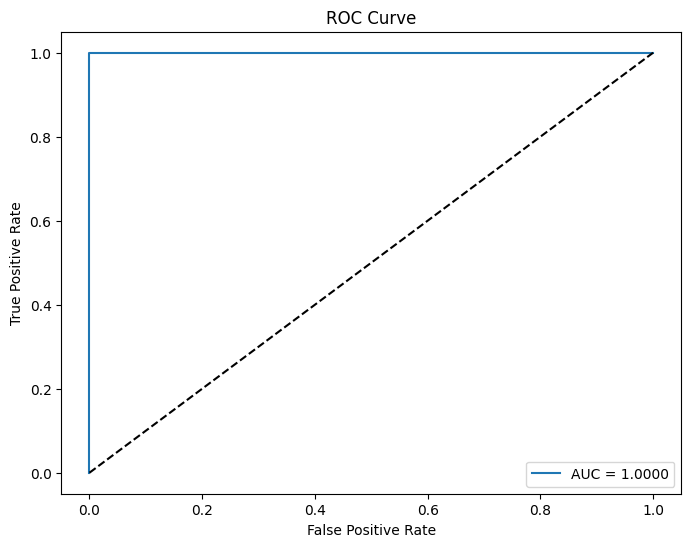

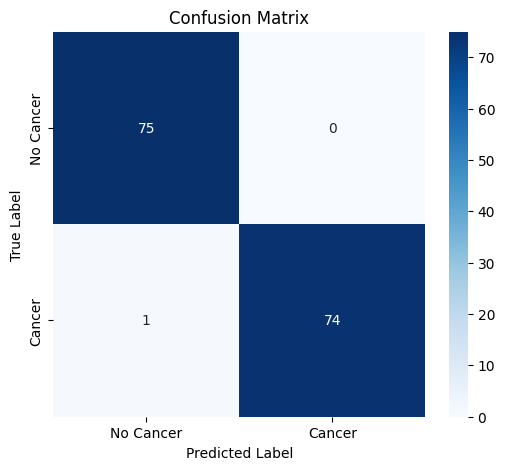

Accuracy: 1.0000
F1 Score: 1.0000
Sensitivity (Recall): 1.0000
Confusion Matrix:
 TN=75, FP=0, FN=0, TP=75
AUC ROC: 1.0000


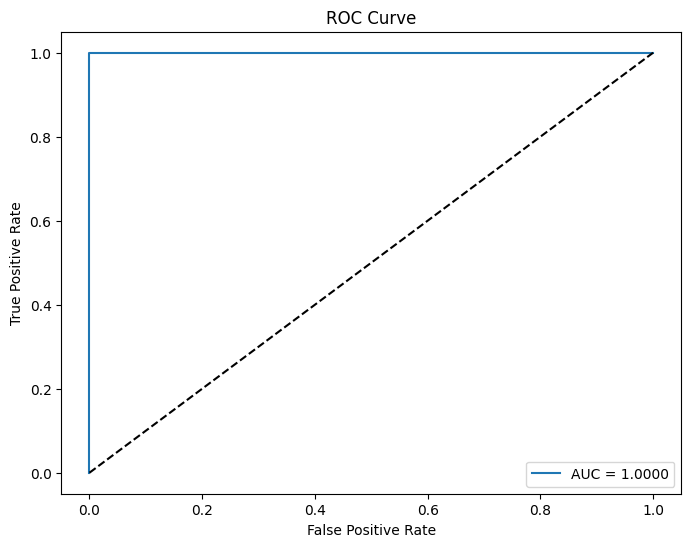

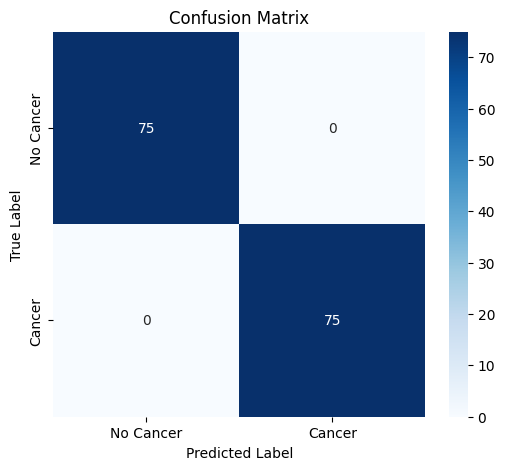

In [ ]:
def evaluate_model(model, data_loader, device):
    model.eval()

    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            probs = torch.softmax(outputs, dim=1)[:, 1]

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    f1 = f1_score(all_labels, all_preds)
    accuracy = accuracy_score(all_labels, all_preds)
    sensitivity = recall_score(all_labels, all_preds)
    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()

    auc_roc = roc_auc_score(all_labels, all_probs)
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Confusion Matrix:\n TN={tn}, FP={fp}, FN={fn}, TP={tp}")
    print(f"AUC ROC: {auc_roc:.4f}")

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc_roc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No Cancer', 'Cancer'], yticklabels=['No Cancer', 'Cancer'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


evaluate_model(model, test_loader, device)
evaluate_model(model, val_loader, device)

In [ ]:
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for test_data, test_target in test_loader:
        test_data, test_target = test_data.to(device), test_target.to(device)
        test_output = model(test_data)
        test_loss += criterion(test_output, test_target).item()
        _, test_predicted = torch.max(test_output.data, 1)
        test_total += test_target.size(0)
        test_correct += (test_predicted == test_target).sum().item()

test_loss /= len(test_loader)
test_accuracy = test_correct / test_total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.0069, Test Accuracy: 0.9933


Accuracy: 0.9933
F1 Score: 0.9933
Sensitivity (Recall): 0.9867
Confusion Matrix:
 TN=75, FP=0, FN=1, TP=74
AUC ROC: 1.0000


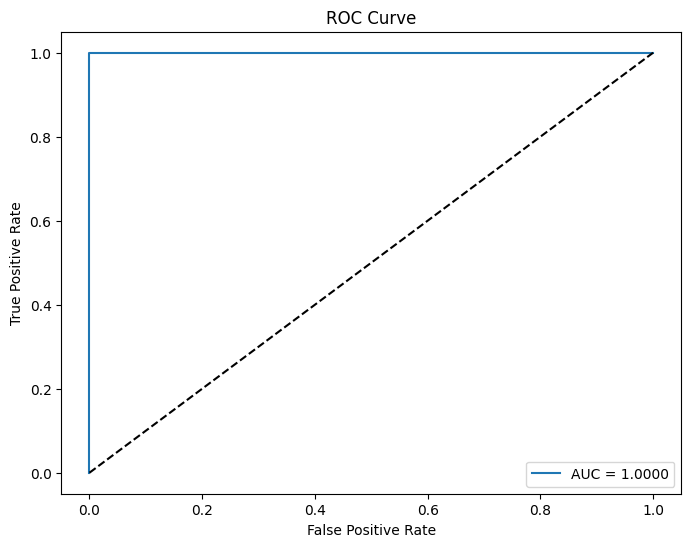

In [ ]:
evaluate_model(model, test_loader, device)

In [ ]:
class ClassicalFeatureExtractor(nn.Module):
    def __init__(self):
        super(ClassicalFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)
        x = self.relu(self.fc1(x))
        return x

dev = qml.device("default.qubit", wires=4)

In [ ]:
@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(4))
    qml.templates.BasicEntanglerLayers(weights, wires=range(4))
    return [qml.expval(qml.PauliZ(i)) for i in range(4)]

In [ ]:
class VQC(nn.Module):
    def __init__(self):
        super(VQC, self).__init__()
        self.weight_shapes = {"weights": (6, 4)}
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, self.weight_shapes)

    def forward(self, x):
        return self.qlayer(x)

class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        self.feature_extractor = ClassicalFeatureExtractor()
        self.fc = nn.Linear(128, 4)
        self.vqc = VQC()

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.fc(x)
        x = self.vqc(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
num_epochs = 30
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_loss_avg = val_running_loss / len(val_loader)
    val_accuracy = val_correct / val_total

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss_avg:.4f}, Val Accuracy: {val_accuracy:.4f}")

    if val_loss_avg < best_val_loss:
        best_val_loss = val_loss_avg
        torch.save(model.state_dict(), 'best_model.pth')

    scheduler.step()

Epoch 1/30, Train Loss: 1.2669, Train Accuracy: 0.3986, Val Loss: 1.0688, Val Accuracy: 0.5867
Epoch 2/30, Train Loss: 1.0550, Train Accuracy: 0.6057, Val Loss: 1.0104, Val Accuracy: 0.7067
Epoch 3/30, Train Loss: 0.9989, Train Accuracy: 0.6786, Val Loss: 0.9860, Val Accuracy: 0.7933
Epoch 4/30, Train Loss: 0.9131, Train Accuracy: 0.8300, Val Loss: 0.8247, Val Accuracy: 0.9667
Epoch 5/30, Train Loss: 0.7583, Train Accuracy: 0.9614, Val Loss: 0.6527, Val Accuracy: 0.9867
Epoch 6/30, Train Loss: 0.6082, Train Accuracy: 0.9900, Val Loss: 0.5473, Val Accuracy: 1.0000
Epoch 7/30, Train Loss: 0.5277, Train Accuracy: 0.9971, Val Loss: 0.4798, Val Accuracy: 1.0000
Epoch 8/30, Train Loss: 0.4700, Train Accuracy: 1.0000, Val Loss: 0.4346, Val Accuracy: 1.0000
Epoch 9/30, Train Loss: 0.4348, Train Accuracy: 0.9986, Val Loss: 0.4293, Val Accuracy: 1.0000
Epoch 10/30, Train Loss: 0.4064, Train Accuracy: 1.0000, Val Loss: 0.3856, Val Accuracy: 1.0000
Epoch 11/30, Train Loss: 0.3948, Train Accuracy: 

In [ ]:
def load_random_image(image_folder_path):
    image_files = [f for f in os.listdir(image_folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    random_image_path = os.path.join(image_folder_path, random.choice(image_files))
    image = Image.open(random_image_path).convert('L')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    image = transform(image)
    return image

def test_random_image(model, image_folder_path):
    model.eval()

    image = load_random_image(image_folder_path)
    image = image.unsqueeze(0).to(device)
    with torch.no_grad():
              output = model(image)

    _, predicted_class = torch.max(output, 1)
    predicted_class = predicted_class.item()

    print(f"Predicted class for the random image: {'Cancer' if predicted_class == 1 else 'No Cancer'}")

image_folder_path = 'output/test/normal'
test_random_image(model, image_folder_path)

Predicted class for the random image: No Cancer


In [ ]:
model.eval()
test_running_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

        test_outputs = model(test_inputs)

        test_loss = criterion(test_outputs, test_labels)

        test_running_loss += test_loss.item()
        _, test_predicted = torch.max(test_outputs.data, 1)
        test_total += test_labels.size(0)
        test_correct += (test_predicted == test_labels).sum().item()

test_loss_avg = test_running_loss / len(test_loader)
test_accuracy = test_correct / test_total

print(f"Test Loss: {test_loss_avg:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.3804, Test Accuracy: 0.9933


Accuracy: 0.9933
F1 Score: 0.9933
Sensitivity (Recall): 0.9867
Confusion Matrix:
 TN=75, FP=0, FN=1, TP=74
AUC ROC: 1.0000


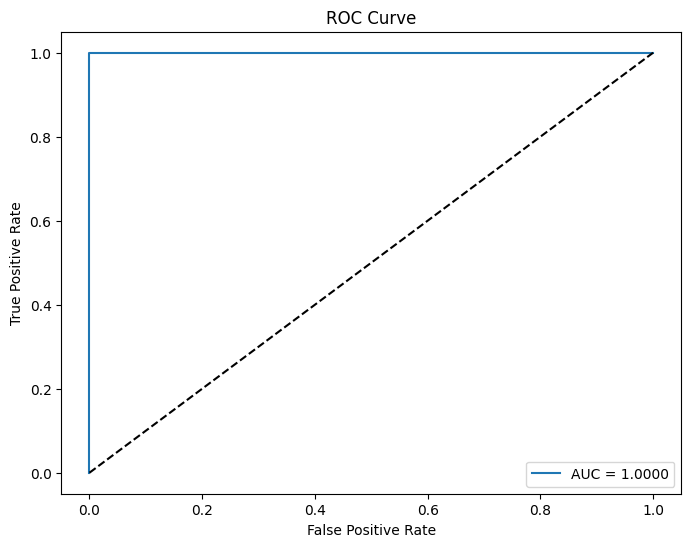

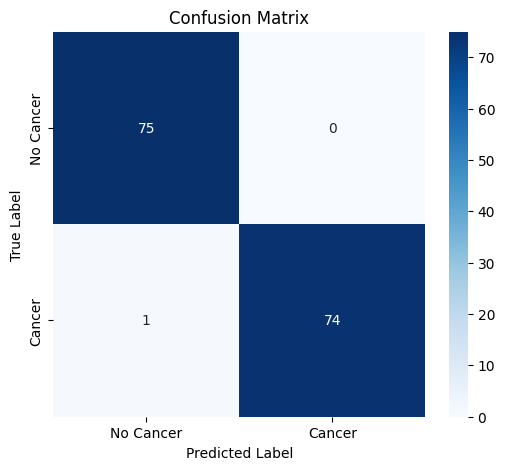

Accuracy: 1.0000
F1 Score: 1.0000
Sensitivity (Recall): 1.0000
Confusion Matrix:
 TN=75, FP=0, FN=0, TP=75
AUC ROC: 1.0000


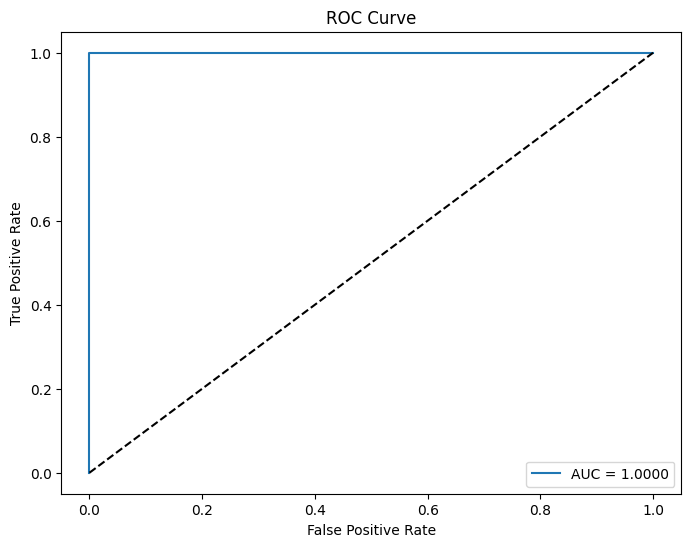

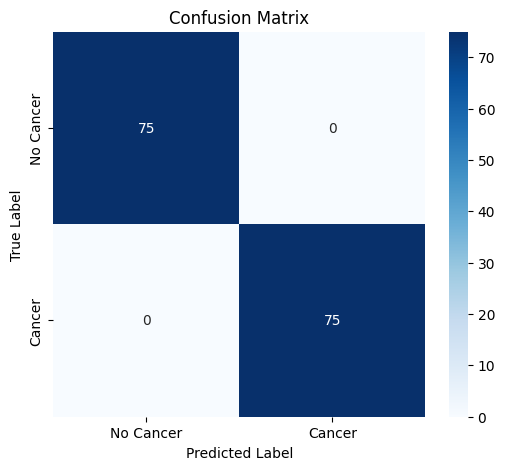

In [ ]:
evaluate_model(model, test_loader, device)
evaluate_model(model, val_loader, device)

In [2]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.5 MB/s eta 0:00:00


In [3]:
import pennylane as qml
from pennylane import numpy as np

# Define the number of qubits
num_qubits = 4

# Define the device
dev = qml.device("default.qubit", wires=num_qubits)

# Define the quantum circuit
@qml.qnode(dev)
def dressed_quantum_circuit(params):
    # Apply Hadamard gates to all qubits
    for i in range(num_qubits):
        qml.Hadamard(wires=i)

    # Apply RY rotations with specified angles
    qml.RY(0.177, wires=0)
    qml.RY(1.53, wires=1)
    qml.RY(1.53, wires=2)
    qml.RY(-1.55, wires=3)

    # Apply controlled operations as per the given circuit
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[2, 3])

    qml.RY(0.0373, wires=0)
    qml.RY(-0.0048, wires=1)
    qml.RY(0.0109, wires=2)
    qml.RY(0.0099, wires=3)

    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[3, 0])

    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[1, 3])

    # Measure the qubits
    return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

# Execute the circuit
params = np.array([], requires_grad=True)
results = dressed_quantum_circuit(params)
print(results)

# Draw the circuit
drawer = qml.draw(dressed_quantum_circuit)
print(drawer(params))


[tensor(0.17729379, requires_grad=True), tensor(0.17612448, requires_grad=True), tensor(-0.99855772, requires_grad=True), tensor(-0.17596751, requires_grad=True)]
0: ──H──RY(0.18)──╭●──RY(0.04)─────╭X─╭●────┤  <Z>
1: ──H──RY(1.53)──╰X──RY(-0.00)─╭●─│──│──╭●─┤  <Z>
2: ──H──RY(1.53)──╭●──RY(0.01)──╰X─│──╰X─│──┤  <Z>
3: ──H──RY(-1.55)─╰X──RY(0.01)─────╰●────╰X─┤  <Z>


[tensor(0.17729379, requires_grad=True), tensor(0.17612448, requires_grad=True), tensor(-0.99855772, requires_grad=True), tensor(-0.17596751, requires_grad=True)]


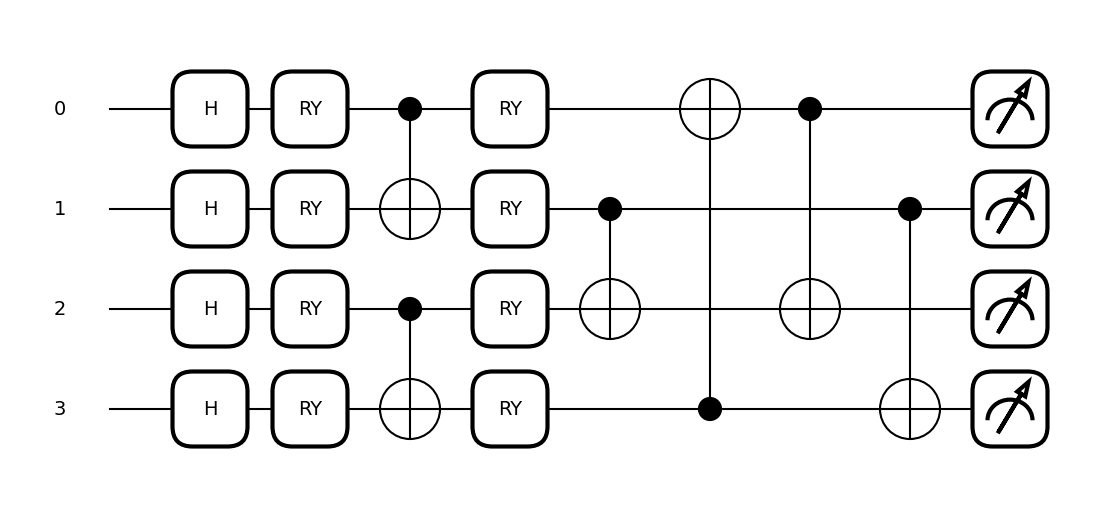

In [4]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# Define the number of qubits
num_qubits = 4

# Define the device
dev = qml.device("default.qubit", wires=num_qubits)

# Define the quantum circuit
@qml.qnode(dev)
def dressed_quantum_circuit(params):
    # Apply Hadamard gates to all qubits
    for i in range(num_qubits):
        qml.Hadamard(wires=i)

    # Apply RY rotations with specified angles
    qml.RY(0.177, wires=0)
    qml.RY(1.53, wires=1)
    qml.RY(1.53, wires=2)
    qml.RY(-1.55, wires=3)

    # Apply controlled operations as per the given circuit
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[2, 3])

    qml.RY(0.0373, wires=0)
    qml.RY(-0.0048, wires=1)
    qml.RY(0.0109, wires=2)
    qml.RY(0.0099, wires=3)

    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[3, 0])

    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[1, 3])

    # Measure the qubits
    return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

# Execute the circuit
params = np.array([], requires_grad=True)
results = dressed_quantum_circuit(params)
print(results)

# Draw the circuit using the MPL drawer
fig, ax = qml.draw_mpl(dressed_quantum_circuit)(params)
plt.show()


Measurement Results: [tensor(0.17729379, requires_grad=True), tensor(0.17612448, requires_grad=True), tensor(-0.99855772, requires_grad=True), tensor(-0.17596751, requires_grad=True)]


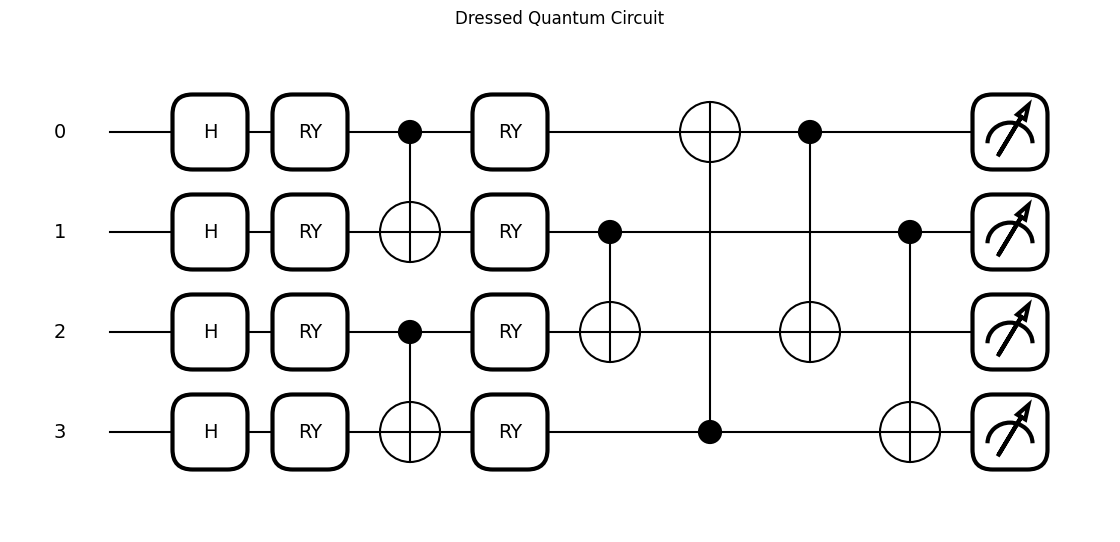

In [8]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

num_qubits = 4

dev = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(dev)
def dressed_quantum_circuit(params):
    for i in range(num_qubits):
        qml.Hadamard(wires=i)

    qml.RY(0.177, wires=0)
    qml.RY(1.53, wires=1)
    qml.RY(1.53, wires=2)
    qml.RY(-1.55, wires=3)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[2, 3])

    qml.RY(0.0373, wires=0)
    qml.RY(-0.0048, wires=1)
    qml.RY(0.0109, wires=2)
    qml.RY(0.0099, wires=3)

    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[3, 0])

    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[1, 3])

    return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

params = np.array([], requires_grad=True)
results = dressed_quantum_circuit(params)
print("Measurement Results:", results)

fig, ax = qml.draw_mpl(dressed_quantum_circuit)(params)
ax.set_title("Dressed Quantum Circuit")
plt.show()
